In [293]:
import pandas as pd
import json
import networkx as nx
import ast
import community

def load_network_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        G = nx.node_link_graph(data)
    return G

file_path = 'data/network_with_attributes_FINAL.json'
G = load_network_from_json(file_path)


network_df = pd.read_csv('data/df_clean_data_with_comm_degree.csv', sep=';', names = ['prod_id','prod','pris/stk','link','catagory','pris','mængde','overkatagori','naboer','description','d_length','ecology','Pairs','community','degree'])

Partition G into communities and assign each node to their resective community. We also update the network_df since the community assigned there are outdated.

In [357]:

communities = nx.community.louvain_communities(G,seed=42)
for idx, community in enumerate(communities):
    for node in community:
        G._node[node]['community']=idx
        network_df.loc[network_df['prod_id']==str(node), 'community'] = idx
network_df=network_df.dropna()
# for node in G.nodes:
#     G._node[node]['community'] = int(network_df[network_df['prod_id']==str(node)]['community'].tolist()[0])

## **Centrality measure** 
We wish to investigate the most central nodes in our network, to find out which wares are the most commonly bought during grocery shopping. We will look at degree, closeness and betweenness centrality and investigate whether these overlap.

**Degree centrality**\
Degreee centrality simply tells how many edges each node in the network has. The assumption is that more central nodes work as hubs in the network and thus have a high degree, we will look at the 15 nodes with the highest degree in order to see what wares work as hubs in the context of grocery shopping. 

In [296]:
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
top15_degree = sorted_degree[:15]
for idx, (node,degree) in enumerate(top15_degree):
    name = G._node[node]['name']
    print(f'The {idx+1}. highest degree product is {name} with {round(degree,4)} degree_centrality')

The 1. highest degree product is agurk with 0.0404 degree_centrality
The 2. highest degree product is agurk with 0.0313 degree_centrality
The 3. highest degree product is skrabeæg m/l with 0.0185 degree_centrality
The 4. highest degree product is peberfrugter røde with 0.0182 degree_centrality
The 5. highest degree product is bananer with 0.017 degree_centrality
The 6. highest degree product is agurk øko with 0.016 degree_centrality
The 7. highest degree product is smørbar with 0.0158 degree_centrality
The 8. highest degree product is æg m/l øko with 0.0132 degree_centrality
The 9. highest degree product is bananer 4 pak øko with 0.0132 degree_centrality
The 10. highest degree product is finvalsede havregryn øko with 0.0132 degree_centrality
The 11. highest degree product is hakkede tomater øko with 0.0124 degree_centrality
The 12. highest degree product is minimælk 0,4% fedt with 0.0111 degree_centrality
The 13. highest degree product is hvedemel øko with 0.01 degree_centrality
The 14

**The closeness centrality**\
Next we will look at closeness centrality, which tell us how "close" each node is to the other nodes in the network, meaning more central nodes have lower scores as they do not have to travel as far along the paths to get to other nodes in the network.\
We still only consider the top 15 most central nodes, in networkx the centrality score is higher for more central nodes, meaning we consider the highest values in this case.

In [297]:
centrality_of_G = nx.closeness_centrality(G)


In [298]:
sorted_closeness = sorted(centrality_of_G.items(), key=lambda item: item[1], reverse=True)
top15_closeness = sorted_closeness[:15]
top15_closeness

[(18364, 0.34026372706342006),
 (29439, 0.33631003689273525),
 (61090, 0.32341921151231806),
 (39411, 0.32219065865098767),
 (53366, 0.3211087700816434),
 (19721, 0.3191336212537626),
 (82376, 0.3181551307978342),
 (119482, 0.31776127182694813),
 (72008, 0.3175957280541808),
 (53365, 0.3173683868028893),
 (40165, 0.3154490475728469),
 (51061, 0.3145335526103641),
 (18381, 0.31242793081358106),
 (41860, 0.3096606241467983),
 (39353, 0.3087588237156152)]

It is interesting to see, which communities these node-hubs bridge across, in order to do this, we iterate over each of our top 15 nodes and look at the assigned communities of their respective neighbours. the dictionary below show the set of communities each node bridges across:

In [339]:
bridge_dict_closeness = dict()
for (node, val) in top15_closeness:
    bridge_dict_closeness[str(node)] = set()
    for (self, neighbour_node) in G.edges(node):
        bridge_dict_closeness[str(self)].add(G._node[neighbour_node]['community'])

closeness_hubs = dict()
for node, bridges in bridge_dict_closeness.items():
    closeness_hubs[G._node[int(node)]['name']] = bridges
closeness_hubs

{'agurk': {3, 4, 10, 11, 14, 16, 18, 19, 21, 22, 24},
 'agurk øko': {4, 11, 16, 18, 20, 24},
 'finvalsede havregryn øko': {11, 16, 18, 24},
 'æg m/l øko': {3, 8, 11, 16, 20, 22, 24},
 'smørbar': {5, 7, 10, 13, 14, 16, 18, 19, 21, 22, 24},
 'hvedemel øko': {10, 14, 16, 18, 22, 24},
 'hakkede tomater øko': {16, 24},
 'bananer 4 pak øko': {4, 11, 16, 17, 18, 24},
 'skrabeæg m/l': {3, 9, 10, 16, 17, 18, 22, 24},
 'rosiner øko': {4, 14, 16, 20, 24},
 'peberfrugter røde': {5, 12, 16, 18, 22, 24},
 'bananer': {4, 6, 11, 12, 16, 17, 18, 21, 24},
 'remoulade øko': {3, 4, 9, 11, 16, 18, 19, 21, 22, 24},
 'mørk pålægschokolade 53% kakao øko': {11, 16, 17, 22, 24}}

**Betweenness centrality**\
This centrality measure tell us which nodes is most often in the shortest path between two arbitrary nodes in the network. Nodes with high betweenness centrality score are usually considered gatekeepers of information and is thus informative to examine in the context of bridging across comunities.

In [333]:
#calculate the betweenness centrality of the entire graph. 
betweenness_of_G = nx.betweenness_centrality(G)

In [334]:
sorted_betweenness = sorted(betweenness_of_G.items(), key=lambda item: item[1], reverse=True)
top15 = sorted_betweenness[:15]
top15

[(18364, 0.029281001959232392),
 (29439, 0.021855598066004425),
 (19721, 0.007246604658721503),
 (39353, 0.006221691778238507),
 (61090, 0.006172700660317658),
 (53366, 0.005927257490907317),
 (39411, 0.005753901560903707),
 (53365, 0.005466864612346025),
 (41860, 0.005017276796866279),
 (82376, 0.00488409846148874),
 (18381, 0.004677436261855312),
 (119482, 0.0045251982613894555),
 (72008, 0.004478263697298725),
 (51061, 0.0042960374872220665),
 (71507, 0.004068930069322418)]

Below we print out the communities our betweenness hubs bridge across. 

In [340]:
bridge_dict = dict()
for (node, val) in top15:
    bridge_dict[str(node)] = set()
    for (self, neighbour_node) in G.edges(node):
        bridge_dict[str(self)].add(G._node[neighbour_node]['community'])
betweenness_hubs = dict()
for node, bridges in bridge_dict.items():
    betweenness_hubs[G._node[int(node)]['name']] = bridges
betweenness_hubs
            

{'agurk': {3, 4, 10, 11, 14, 16, 18, 19, 21, 22, 24},
 'smørbar': {5, 7, 10, 13, 14, 16, 18, 19, 21, 22, 24},
 'mørk pålægschokolade 53% kakao øko': {11, 16, 17, 22, 24},
 'agurk øko': {4, 11, 16, 18, 20, 24},
 'æg m/l øko': {3, 8, 11, 16, 20, 22, 24},
 'finvalsede havregryn øko': {11, 16, 18, 24},
 'skrabeæg m/l': {3, 9, 10, 16, 17, 18, 22, 24},
 'remoulade øko': {3, 4, 9, 11, 16, 18, 19, 21, 22, 24},
 'hvedemel øko': {10, 14, 16, 18, 22, 24},
 'bananer': {4, 6, 11, 12, 16, 17, 18, 21, 24},
 'hakkede tomater øko': {16, 24},
 'bananer 4 pak øko': {4, 11, 16, 17, 18, 24},
 'peberfrugter røde': {5, 12, 16, 18, 22, 24},
 'tonic': {2, 3, 6, 8, 16, 18, 19, 24}}

In [300]:
#network_df.to_csv('data/df_clean_data_updated_comm.csv', sep=';')

We examine which categories is in a given community, partly to make sure the communities isn't simply the default categories from the salling website. We do this by making a set of all the different categories the nodes in the given community contains. 

In [341]:
# Ikke relevant alligevel, vi finder at kategorierne ikke overlapper med communities overhovedet.
node_dict = nx.get_node_attributes(G,'community')
community_categories = dict()
for com in range(max(node_dict.values())):
    community_categories[com] = {G._node[node]['category'] for node, community in node_dict.items() if community==com}
#community_categories

{0: {'frost', 'kolonial', 'mejeri-og-koel', 'slik-og-snacks'},
 1: {'broed-og-kager', 'drikkevarer', 'kolonial', 'mejeri-og-koel'},
 2: {'drikkevarer', 'kolonial', 'mejeri-og-koel', 'slik-og-snacks'},
 3: {'broed-og-kager',
  'drikkevarer',
  'frost',
  'frugt-og-groent',
  'koed-og-fisk',
  'kolonial',
  'mejeri-og-koel',
  'slik-og-snacks'},
 4: {'broed-og-kager',
  'drikkevarer',
  'frost',
  'frugt-og-groent',
  'koed-og-fisk',
  'kolonial',
  'mejeri-og-koel',
  'slik-og-snacks'},
 5: {'kolonial', 'mejeri-og-koel', 'slik-og-snacks'},
 6: {'broed-og-kager',
  'drikkevarer',
  'frost',
  'kolonial',
  'mejeri-og-koel',
  'slik-og-snacks'},
 7: {'broed-og-kager',
  'drikkevarer',
  'frost',
  'koed-og-fisk',
  'kolonial',
  'mejeri-og-koel',
  'slik-og-snacks'},
 8: {'broed-og-kager',
  'drikkevarer',
  'frost',
  'frugt-og-groent',
  'koed-og-fisk',
  'kolonial',
  'mejeri-og-koel',
  'slik-og-snacks'},
 9: {'broed-og-kager',
  'drikkevarer',
  'frost',
  'koed-og-fisk',
  'kolonial

We want to get a subgraph containing the 5 largest communities, so that we can plot these to show the magnitude of the amount of products within, as well as label them using the information we get in the NLP section.

In [370]:
top5_biggest = list()
sorted_comms = sorted(communities, key=len, reverse =True)
for com in sorted_comms[:5]:
   top5_biggest.append(G._node[next(iter(com))]['community'])
top5_biggest

[16, 24, 18, 19, 3]

Make a subgraph based on communities

In [311]:
def get_subgraph(community_list):
    '''
    input: A list or set of communities to filter for.

    output: A networkx subgraph containing only the nodes in the given communities.
    '''
    nodes = []
    for community in community_list:
        nodes.extend(community)
    return G.subgraph(nodes)
subgraph = get_subgraph(sorted_comms[:5])
#subgraph = get_subgraph([0,5])
#nodes = (node for node, data in G.nodes(data=True) if data.get("community") in community_list and G.degree(node)>=1)
len(subgraph)

5551

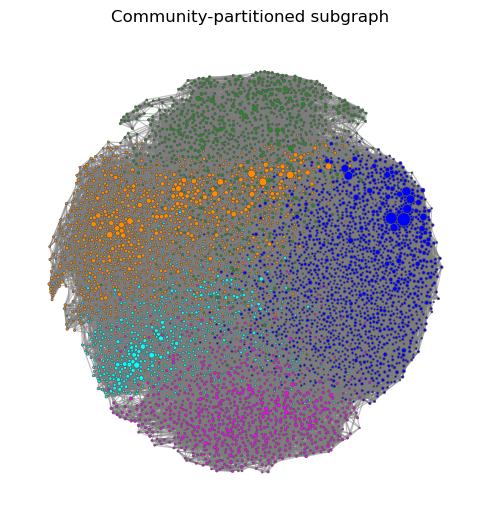

In [332]:
def vis_graph(graph, title='Community-partitioned subgraph'):
    import matplotlib.colors as mcolors
    from netwulf import visualize, draw_netwulf

    colors = ['cyan','blue','forestgreen','magenta','darkorange','dark_violet'] #list(mcolors.TABLEAU_COLORS.keys())
    n_colors = len(colors) 

    sorted_communities = dict(sorted(nx.get_node_attributes(subgraph,'community').items(),key=lambda x: x[1],reverse=True))
    community_colors = {community: colors[i % n_colors] for i, community in enumerate(set(sorted_communities.values()))}

    for idx, (node, commun) in enumerate(sorted_communities.items()):
        graph.nodes[node]['color'] = community_colors[commun]

    network, _ = visualize(graph)
    fig, ax = draw_netwulf(network)
    ax.set_title(title)
vis_graph(subgraph)

In [342]:
sorted_communities = sorted(nx.get_node_attributes(subgraph,'community').items(),key=lambda x: x[1],reverse=True)
sorted_communities

[(18950, 24),
 (76001, 24),
 (81409, 24),
 (123516, 24),
 (92896, 24),
 (116554, 24),
 (110018, 24),
 (107681, 24),
 (88422, 24),
 (88157, 24),
 (87183, 24),
 (85381, 24),
 (32151, 24),
 (122732, 24),
 (30785, 24),
 (92895, 24),
 (85164, 24),
 (38428, 24),
 (110733, 24),
 (39504, 24),
 (20006, 24),
 (59060, 24),
 (83770, 24),
 (86635, 24),
 (78062, 24),
 (115242, 24),
 (108349, 24),
 (92461, 24),
 (126470, 24),
 (92084, 24),
 (87035, 24),
 (85163, 24),
 (83321, 24),
 (44266, 24),
 (16906, 24),
 (108396, 24),
 (114736, 24),
 (85198, 24),
 (63814, 24),
 (91518, 24),
 (64851, 24),
 (90285, 24),
 (79258, 24),
 (19687, 24),
 (92712, 24),
 (92714, 24),
 (69486, 24),
 (21089, 24),
 (39150, 24),
 (72579, 24),
 (41870, 24),
 (33278, 24),
 (51609, 24),
 (54520, 24),
 (53366, 24),
 (76483, 24),
 (57652, 24),
 (51575, 24),
 (40268, 24),
 (110061, 24),
 (88005, 24),
 (68949, 24),
 (75836, 24),
 (73358, 24),
 (65333, 24),
 (73620, 24),
 (88168, 24),
 (81978, 24),
 (79226, 24),
 (73896, 24),
 (91514,